imagenet, channel3, adam0.0001, classweight

In [ ]:
# 모듈 호출
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
import os
import seaborn as sns
import sklearn.metrics

In [ ]:
img_size = 224
channel=3

In [ ]:
train_path = '/content/drive/MyDrive/Final_Project/Train_data/dry_scalp'
valid_path = '/content/drive/MyDrive/Final_Project/Validation/dry_scalp'
test_path = '/content/drive/MyDrive/Final_Project/Test/dry_scalp'

In [ ]:
subject = train_path.split('/')[-1]
subject

'dry_scalp'

In [ ]:
labels=pd.Series(os.listdir(train_path))

labels=labels.sort_values()
labels=labels.to_list()
labels

['dry_scalp_0', 'dry_scalp_1', 'dry_scalp_2', 'dry_scalp_3']

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,         # 픽셀 값을 0~1 범위로 변환
    zoom_range= [0.9,1],
    horizontal_flip=True,   # 좌우 뒤집기
    vertical_flip = True
)
train_generator = train_datagen.flow_from_directory(
    train_path,
    batch_size=50,
    class_mode='categorical',
    target_size=(img_size, img_size))

valid_datagen = ImageDataGenerator(
    rescale=1./255,         # 픽셀 값을 0~1 범위로 변환
)
valid_generator = valid_datagen.flow_from_directory(
    valid_path,
    # batch_size=20,
    class_mode='categorical',
    target_size=(img_size, img_size))

test_datagen = ImageDataGenerator(
    rescale=1./255,         # 픽셀 값을 0~1 범위로 변환
)
test_generator = test_datagen.flow_from_directory(
    test_path,
    # batch_size=10,
    class_mode='categorical',
    target_size=(img_size, img_size),
    shuffle=False)

Found 20438 images belonging to 4 classes.
Found 3188 images belonging to 4 classes.
Found 1819 images belonging to 4 classes.


In [ ]:
class_path = glob.glob(train_path + '/*')
class_path

['/content/drive/MyDrive/Final_Project/Train_data/dry_scalp/dry_scalp_2',
 '/content/drive/MyDrive/Final_Project/Train_data/dry_scalp/dry_scalp_3',
 '/content/drive/MyDrive/Final_Project/Train_data/dry_scalp/dry_scalp_1',
 '/content/drive/MyDrive/Final_Project/Train_data/dry_scalp/dry_scalp_0']

In [ ]:
len(glob.glob('/content/drive/MyDrive/Final_Project/Train_data/dry_scalp/dry_scalp_2/*'))

5486

In [ ]:
classNum = []
fileNum = []
for path in class_path :
    fileNum.append(len(glob.glob(path + '/*')))
    classNum.append(int(path.split('_')[-1]))

label_dic = dict(zip(classNum, fileNum))
label_dic

{0: 4588, 1: 4435, 2: 5486, 3: 5929}

In [ ]:
#class weight 지정 함수
import math

# labels_dict : {ind_label: count_label}
# mu : parameter to tune

def create_class_weight(labels_dict,mu=0.15):
    total = sum(labels_dict.values())
    keys = labels_dict.keys()
    class_weight = dict()

    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        score = round(score, 3)
        class_weight[key] = score if score > 1.0 else 1.0

    return class_weight

In [ ]:
class_weight = create_class_weight(label_dic)
class_weight

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}

In [ ]:
# 파라미터 설정
classes = len(train_generator.class_indices)
epochs = 100
batch_size = 32

In [ ]:
MobileNet = tf.keras.applications.MobileNetV2(include_top=False,
                                              weights='imagenet',
                                              input_shape=(img_size, img_size, channel))
MobileNet.trainable = False # 학습으로 기존 가중치 갱신을 하지 않도록 지정

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
model = Sequential()
model.add(MobileNet)
model.add(Flatten(input_shape=(112,112)))
model.add(Dense(224, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 224)               14049504  
                                                                 
 dropout (Dropout)           (None, 224)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 900       
                                                                 
Total params: 16,308,388
Trainable params: 14,050,404
Non-trainable params: 2,257,984
____________________________________

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_name = './MobileNet_dryscalp_1_{epoch:02d}-{val_loss:.4f}.hdf5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = model_name,
                                                 monitor = 'val_loss',
                                                 verbose = 1, save_best_only = True)
earlystop = EarlyStopping(monitor = 'val_loss', patience = 7)

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=200,
                    epochs=epochs,
                    validation_data=valid_generator,
                    validation_steps=50,
                    callbacks = [[earlystop, cp_callback]],
                    class_weight = class_weight)

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 1.0387 - accuracy: 0.5970 
Epoch 1: val_loss improved from inf to 1.00942, saving model to ./MobileNet_dryscalp_1_01-1.0094.hdf5
200/200 [==============================] - 2705s 13s/step - loss: 1.0387 - accuracy: 0.5970 - val_loss: 1.0094 - val_accuracy: 0.5706
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.7335 - accuracy: 0.6847
Epoch 2: val_loss improved from 1.00942 to 0.88490, saving model to ./MobileNet_dryscalp_1_02-0.8849.hdf5
200/200 [==============================] - 1479s 7s/step - loss: 0.7335 - accuracy: 0.6847 - val_loss: 0.8849 - val_accuracy: 0.6187
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.6824 - accuracy: 0.6982
Epoch 3: val_loss improved from 0.88490 to 0.81353, saving model to ./MobileNet_dryscalp_1_03-0.8135.hdf5
200/200 [==============================] - 865s 4s/step - loss: 0.6824 - accuracy: 0.6982 - val_loss: 0.8135 - val_accuracy: 0.

evaluate

In [ ]:
max(history.history['accuracy'])

0.7462955713272095

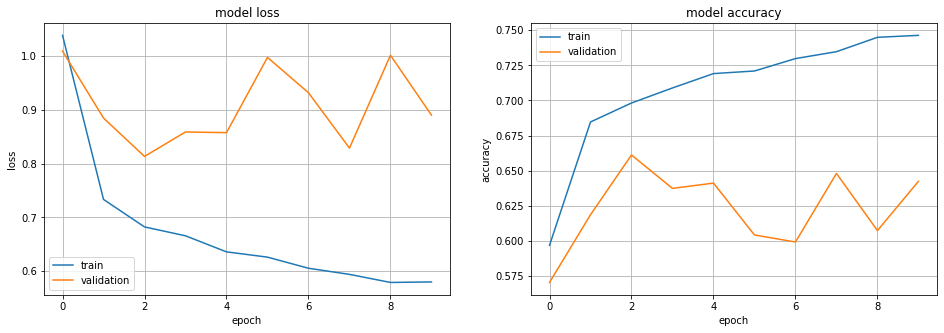

In [ ]:
plt.figure(figsize=(16,5))

# 만들어진 모델에 대해 train dataset과 validation dataset의 loss 를 그래프로 표현해 봅니다.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.grid()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc=0)

# 만들어진 모델에 대해 train dataset과 validation dataset의 accuracy 를 그래프로 표현해 봅니다.
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc=0)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(test_generator)
classes = test_generator.classes[test_generator.index_array]
y_pred = np.argmax(Y_pred, axis=1)

result_dict = dict(map(reversed, test_generator.class_indices.items()))
class_names = list(result_dict.values())

print('-- Confusion Matrix --')
print(confusion_matrix(classes, y_pred))

print('-- Classification Report --')
print(classification_report(classes, y_pred, target_names=class_names))

-- Confusion Matrix --
[[ 16  57   3   0]
 [ 12 356 259   6]
 [  2 189 532  61]
 [  0  15 185 126]]
-- Classification Report --
              precision    recall  f1-score   support

 dry_scalp_0       0.53      0.21      0.30        76
 dry_scalp_1       0.58      0.56      0.57       633
 dry_scalp_2       0.54      0.68      0.60       784
 dry_scalp_3       0.65      0.39      0.49       326

    accuracy                           0.57      1819
   macro avg       0.58      0.46      0.49      1819
weighted avg       0.57      0.57      0.56      1819



Text(0.5, 1.0, 'dry_scalp_confusion matrix')

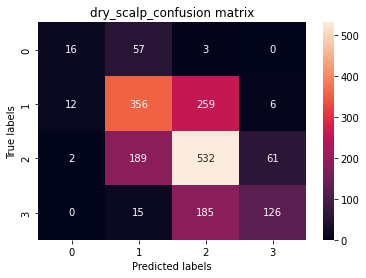

In [ ]:
ax = plt.subplot()
sns.heatmap(confusion_matrix(classes, y_pred), annot=True, fmt='d' )
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title(f'{subject}_confusion matrix')